# Import packages

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np

sns.set(color_codes=True)
pd.options.display.max_colwidth = 500

# Import required data

In [2]:
seg_data_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/image/segmentation.data' 
segmentation_data = pd.read_csv(seg_data_url, sep=',', skiprows=2)
print(segmentation_data.shape)

(210, 19)


In [3]:
segmentation_data.head()

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
BRICKFACE,140.0,125.0,9,0.0,0.0,0.277778,0.062963,0.666667,0.311111,6.185185,7.333334,7.666666,3.555556,3.444444,4.444445,-7.888889,7.777778,0.545635,-1.121818
BRICKFACE,188.0,133.0,9,0.0,0.0,0.333333,0.266667,0.500000,0.077778,6.666666,8.333334,7.777778,3.888889,5.000000,3.333333,-8.333333,8.444445,0.538580,-0.924817
BRICKFACE,105.0,139.0,9,0.0,0.0,0.277778,0.107407,0.833333,0.522222,6.111111,7.555555,7.222222,3.555556,4.333334,3.333333,-7.666666,7.555555,0.532628,-0.965946
BRICKFACE,34.0,137.0,9,0.0,0.0,0.500000,0.166667,1.111111,0.474074,5.851852,7.777778,6.444445,3.333333,5.777778,1.777778,-7.555555,7.777778,0.573633,-0.744272
BRICKFACE,39.0,111.0,9,0.0,0.0,0.722222,0.374074,0.888889,0.429629,6.037037,7.000000,7.666666,3.444444,2.888889,4.888889,-7.777778,7.888889,0.562919,-1.175773


In [4]:
seg_test_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/image/segmentation.test' 
segmentation_test = pd.read_csv(seg_test_url, sep=',', skiprows=2)
print(segmentation_test.shape)

(2100, 19)


In [5]:
segmentation_test.head()

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
GRASS,110.0,189.0,9,0.0,0.0,1.000000,0.666667,1.222222,1.186342,12.925926,10.888889,9.222222,18.666668,-6.111111,-11.111111,17.222221,18.666668,0.508139,1.910864
GRASS,86.0,187.0,9,0.0,0.0,1.111111,0.720082,1.444444,0.750309,13.740741,11.666667,10.333334,19.222221,-6.222222,-10.222222,16.444445,19.222221,0.463329,1.941465
GRASS,225.0,244.0,9,0.0,0.0,3.388889,2.195113,3.000000,1.520234,12.259259,10.333334,9.333334,17.111110,-5.777778,-8.777778,14.555555,17.111110,0.480149,1.987902
GRASS,47.0,232.0,9,0.0,0.0,1.277778,1.254621,1.000000,0.894427,12.703704,11.000000,9.000000,18.111110,-5.111111,-11.111111,16.222221,18.111110,0.500966,1.875362
GRASS,97.0,186.0,9,0.0,0.0,1.166667,0.691215,1.166667,1.005540,15.592592,13.888889,11.777778,21.111110,-5.111111,-11.444445,16.555555,21.111110,0.442661,1.863654


# Merge data into one file

In [6]:
data = pd.concat([segmentation_data, segmentation_test])

In [7]:
# add index and class column
data= data.reset_index()
data= data.rename(columns={'index': 'Class'})
print(data.shape)

(2310, 20)


In [8]:
data.head()

,Class,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
0,BRICKFACE,140.0,125.0,9,0.0,0.0,0.277778,0.062963,0.666667,0.311111,6.185185,7.333334,7.666666,3.555556,3.444444,4.444445,-7.888889,7.777778,0.545635,-1.121818
1,BRICKFACE,188.0,133.0,9,0.0,0.0,0.333333,0.266667,0.500000,0.077778,6.666666,8.333334,7.777778,3.888889,5.000000,3.333333,-8.333333,8.444445,0.538580,-0.924817
2,BRICKFACE,105.0,139.0,9,0.0,0.0,0.277778,0.107407,0.833333,0.522222,6.111111,7.555555,7.222222,3.555556,4.333334,3.333333,-7.666666,7.555555,0.532628,-0.965946
3,BRICKFACE,34.0,137.0,9,0.0,0.0,0.500000,0.166667,1.111111,0.474074,5.851852,7.777778,6.444445,3.333333,5.777778,1.777778,-7.555555,7.777778,0.573633,-0.744272
4,BRICKFACE,39.0,111.0,9,0.0,0.0,0.722222,0.374074,0.888889,0.429629,6.037037,7.000000,7.666666,3.444444,2.888889,4.888889,-7.777778,7.888889,0.562919,-1.175773


### number of instances  = 2310

In [9]:
print(data.shape[0])

2310


### number of attributes = 19
*one column for className* 

In [10]:
print(data.shape[1])

20


### number of classes = 7

In [11]:
classes = data['Class'].unique()
print("class names : ",  classes)
print("number of classes: ", len(classes))

class names :  ['BRICKFACE' 'SKY' 'FOLIAGE' 'CEMENT' 'WINDOW' 'PATH' 'GRASS']
number of classes:  7


# Data Explortions

## Histogram plots

In [12]:
def get_list_of_lists(class_name):
    
    # select data with specefic class_name
    new_data = data.loc[data['Class'] == class_name]
    data_to_plot = []
    
    # make each columns as list and return data as list of lists
    i = 1
    while i < len(new_data.columns):
        column_list = list(new_data.iloc[:,i])
        data_to_plot.append(column_list)
        i = i + 1
    return data_to_plot

In [13]:
# prepare colors and lablel names of the images
list1 = sns.color_palette("husl", 7)
list1 += sns.color_palette("Paired")
colors = list1
column_names = list(data.columns.values)[1:]
print(column_names)

['REGION-CENTROID-COL', 'REGION-CENTROID-ROW', 'REGION-PIXEL-COUNT', 'SHORT-LINE-DENSITY-5', 'SHORT-LINE-DENSITY-2', 'VEDGE-MEAN', 'VEDGE-SD', 'HEDGE-MEAN', 'HEDGE-SD', 'INTENSITY-MEAN', 'RAWRED-MEAN', 'RAWBLUE-MEAN', 'RAWGREEN-MEAN', 'EXRED-MEAN', 'EXBLUE-MEAN', 'EXGREEN-MEAN', 'VALUE-MEAN', 'SATURATION-MEAN', 'HUE-MEAN']


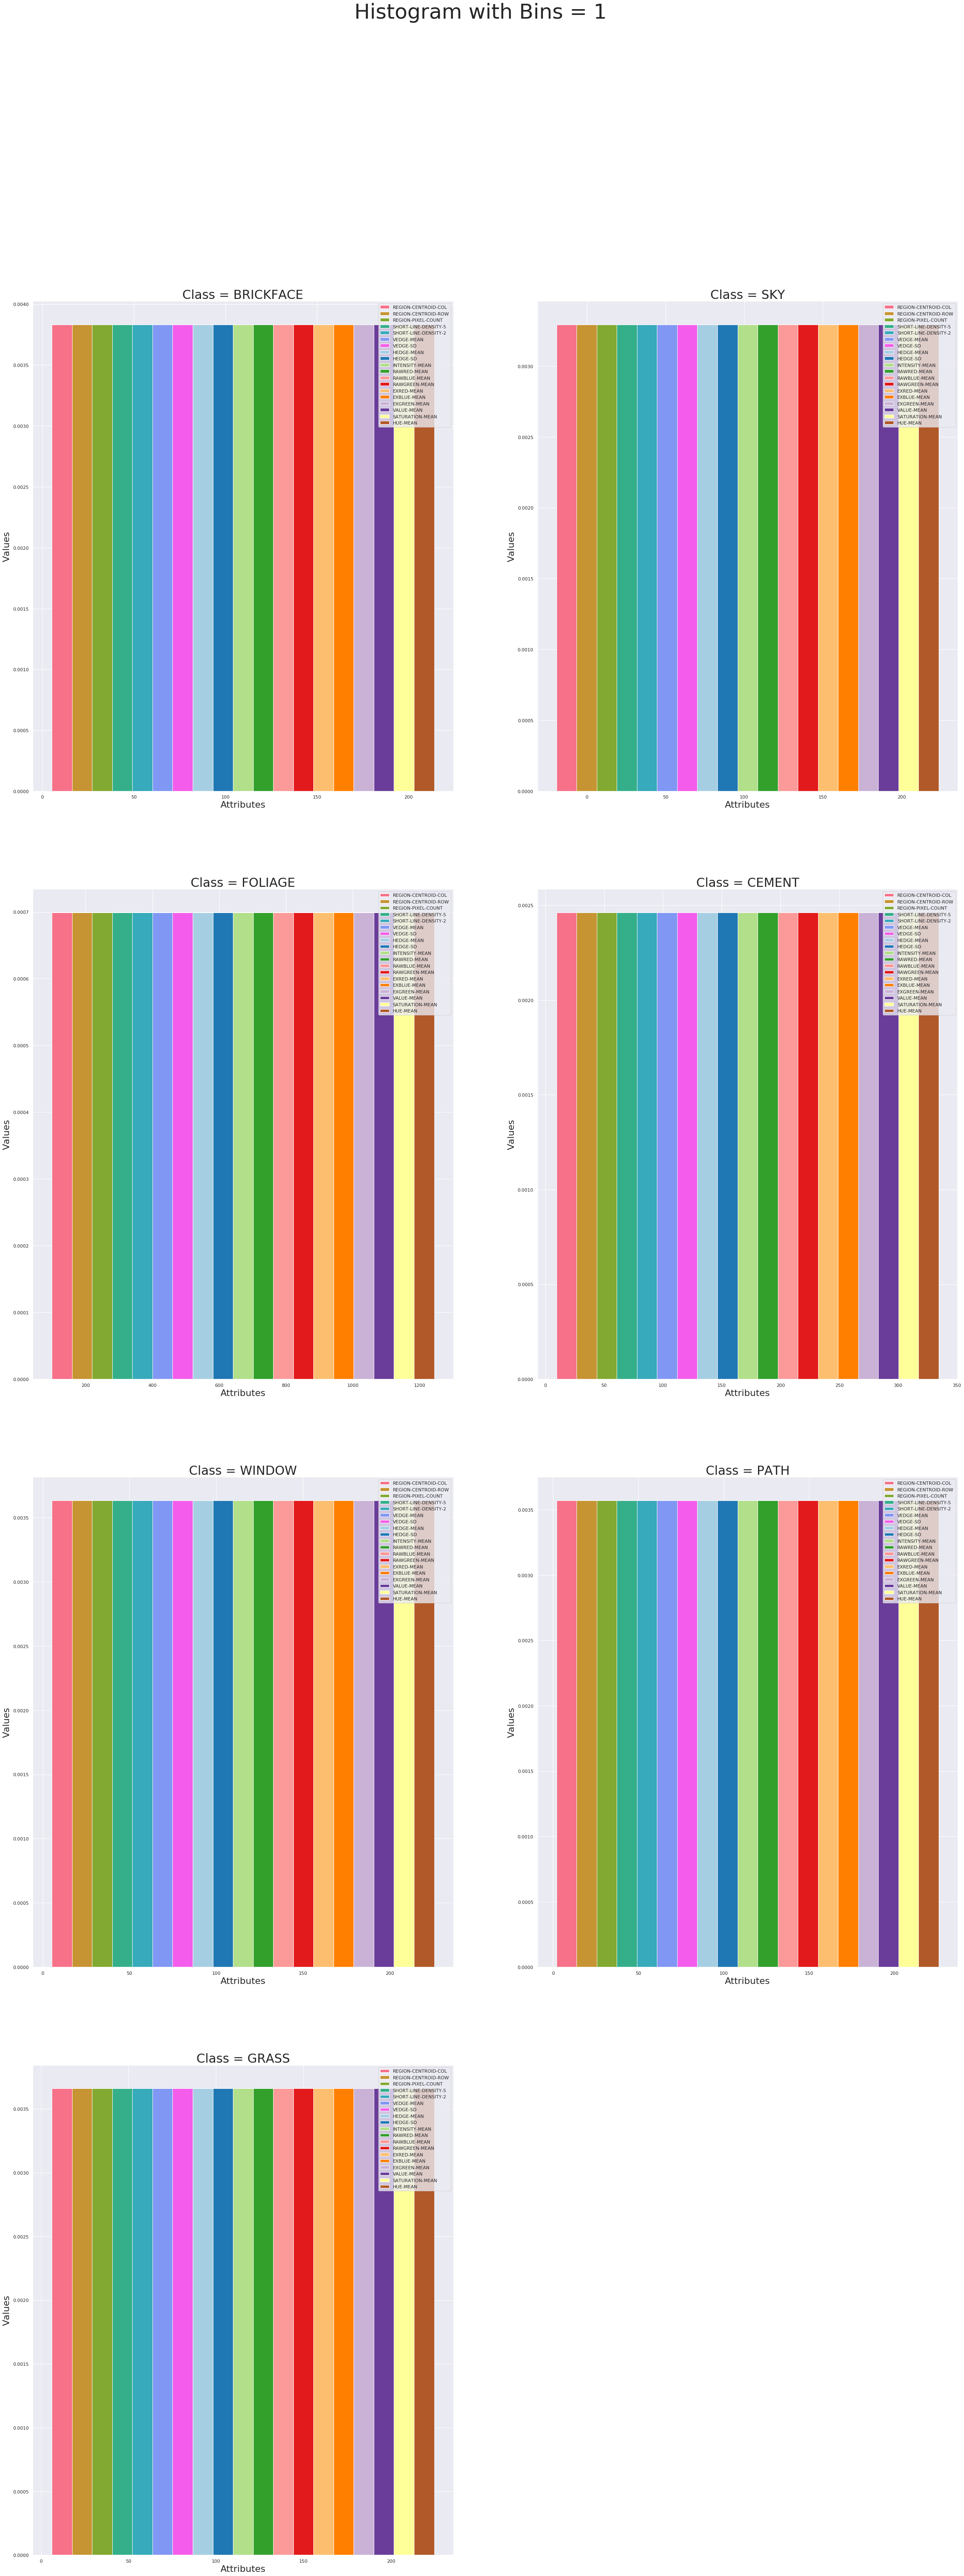

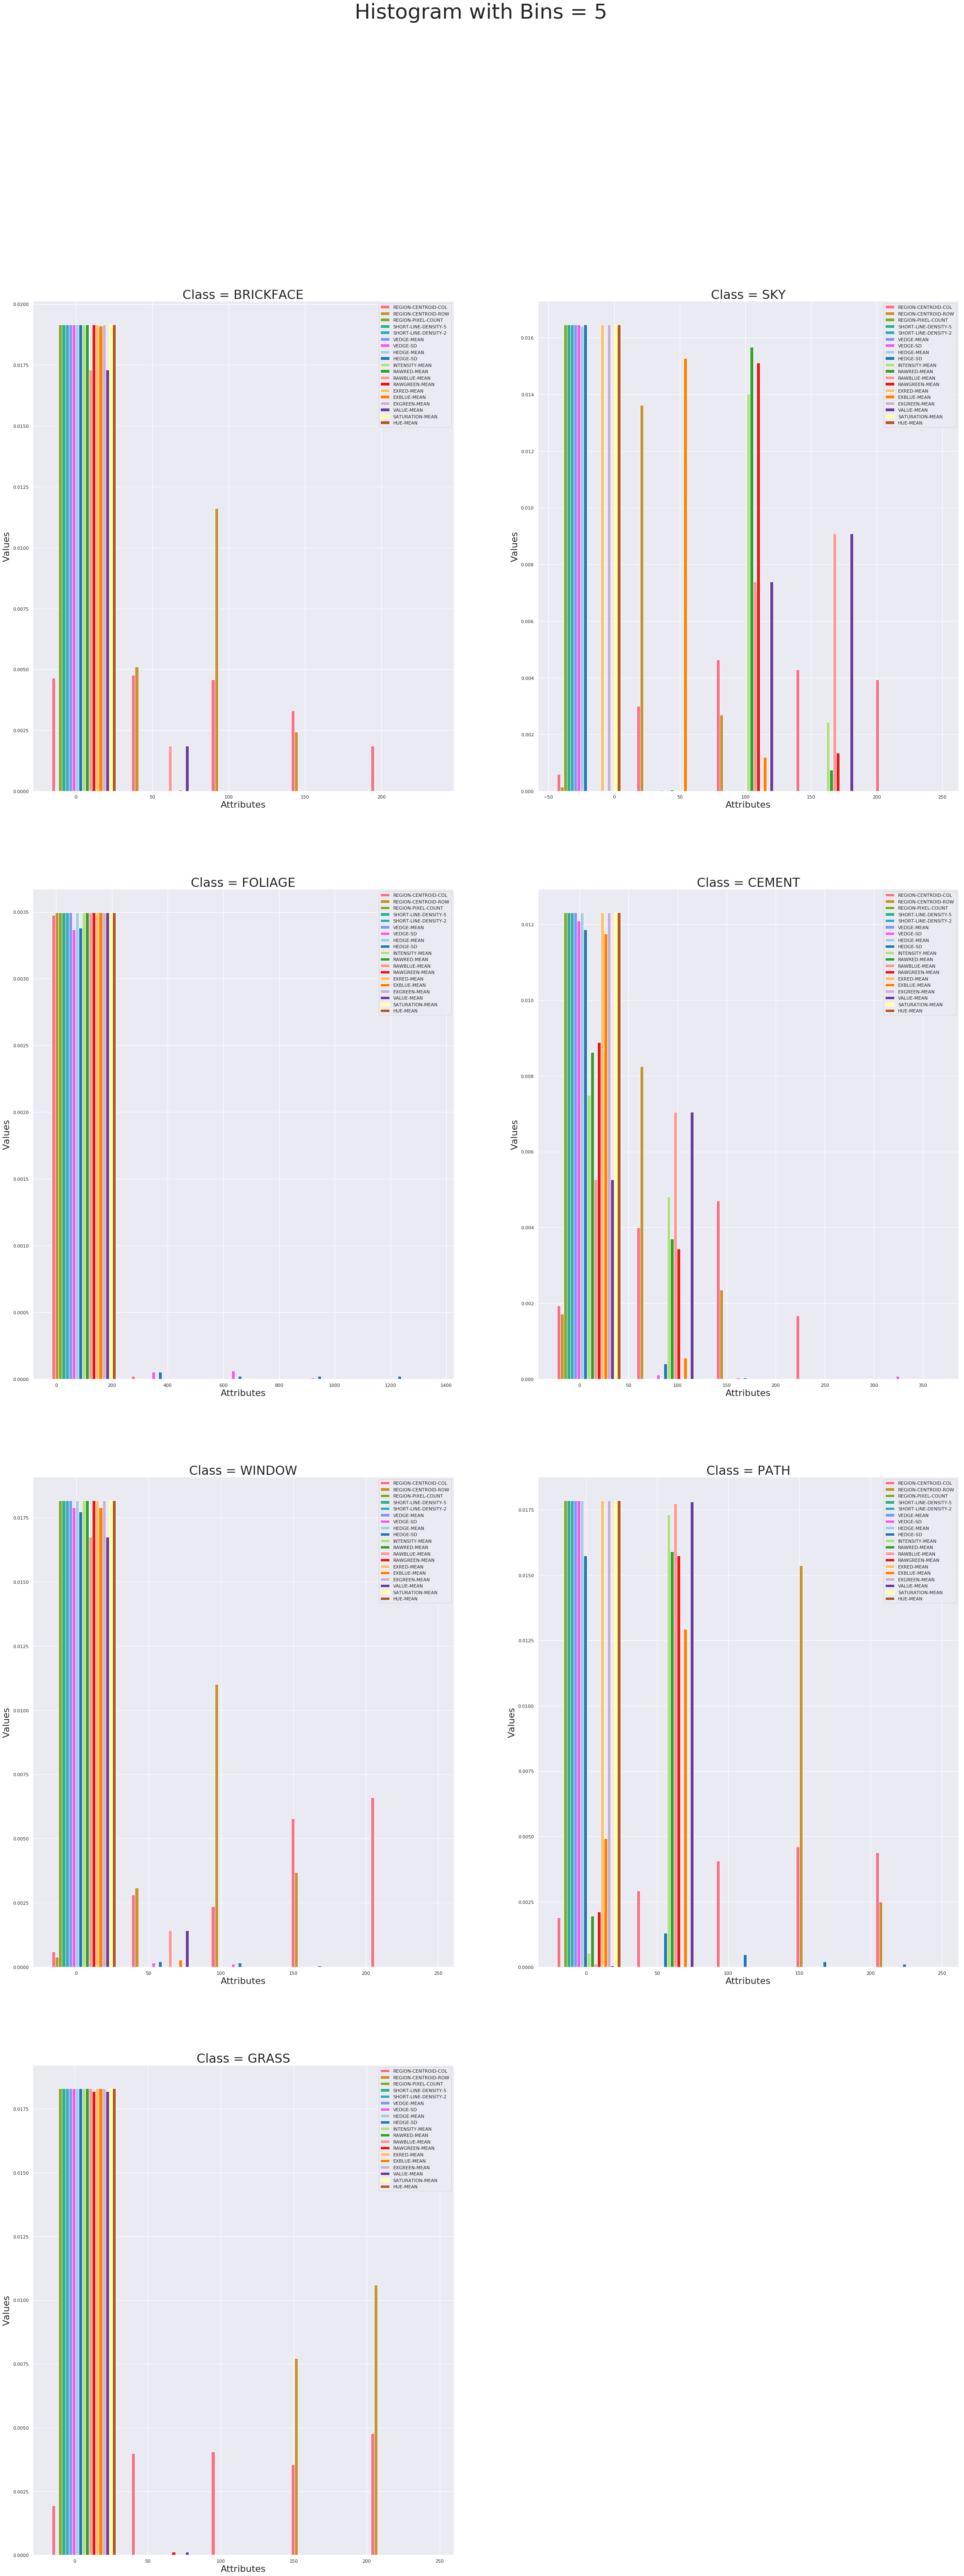

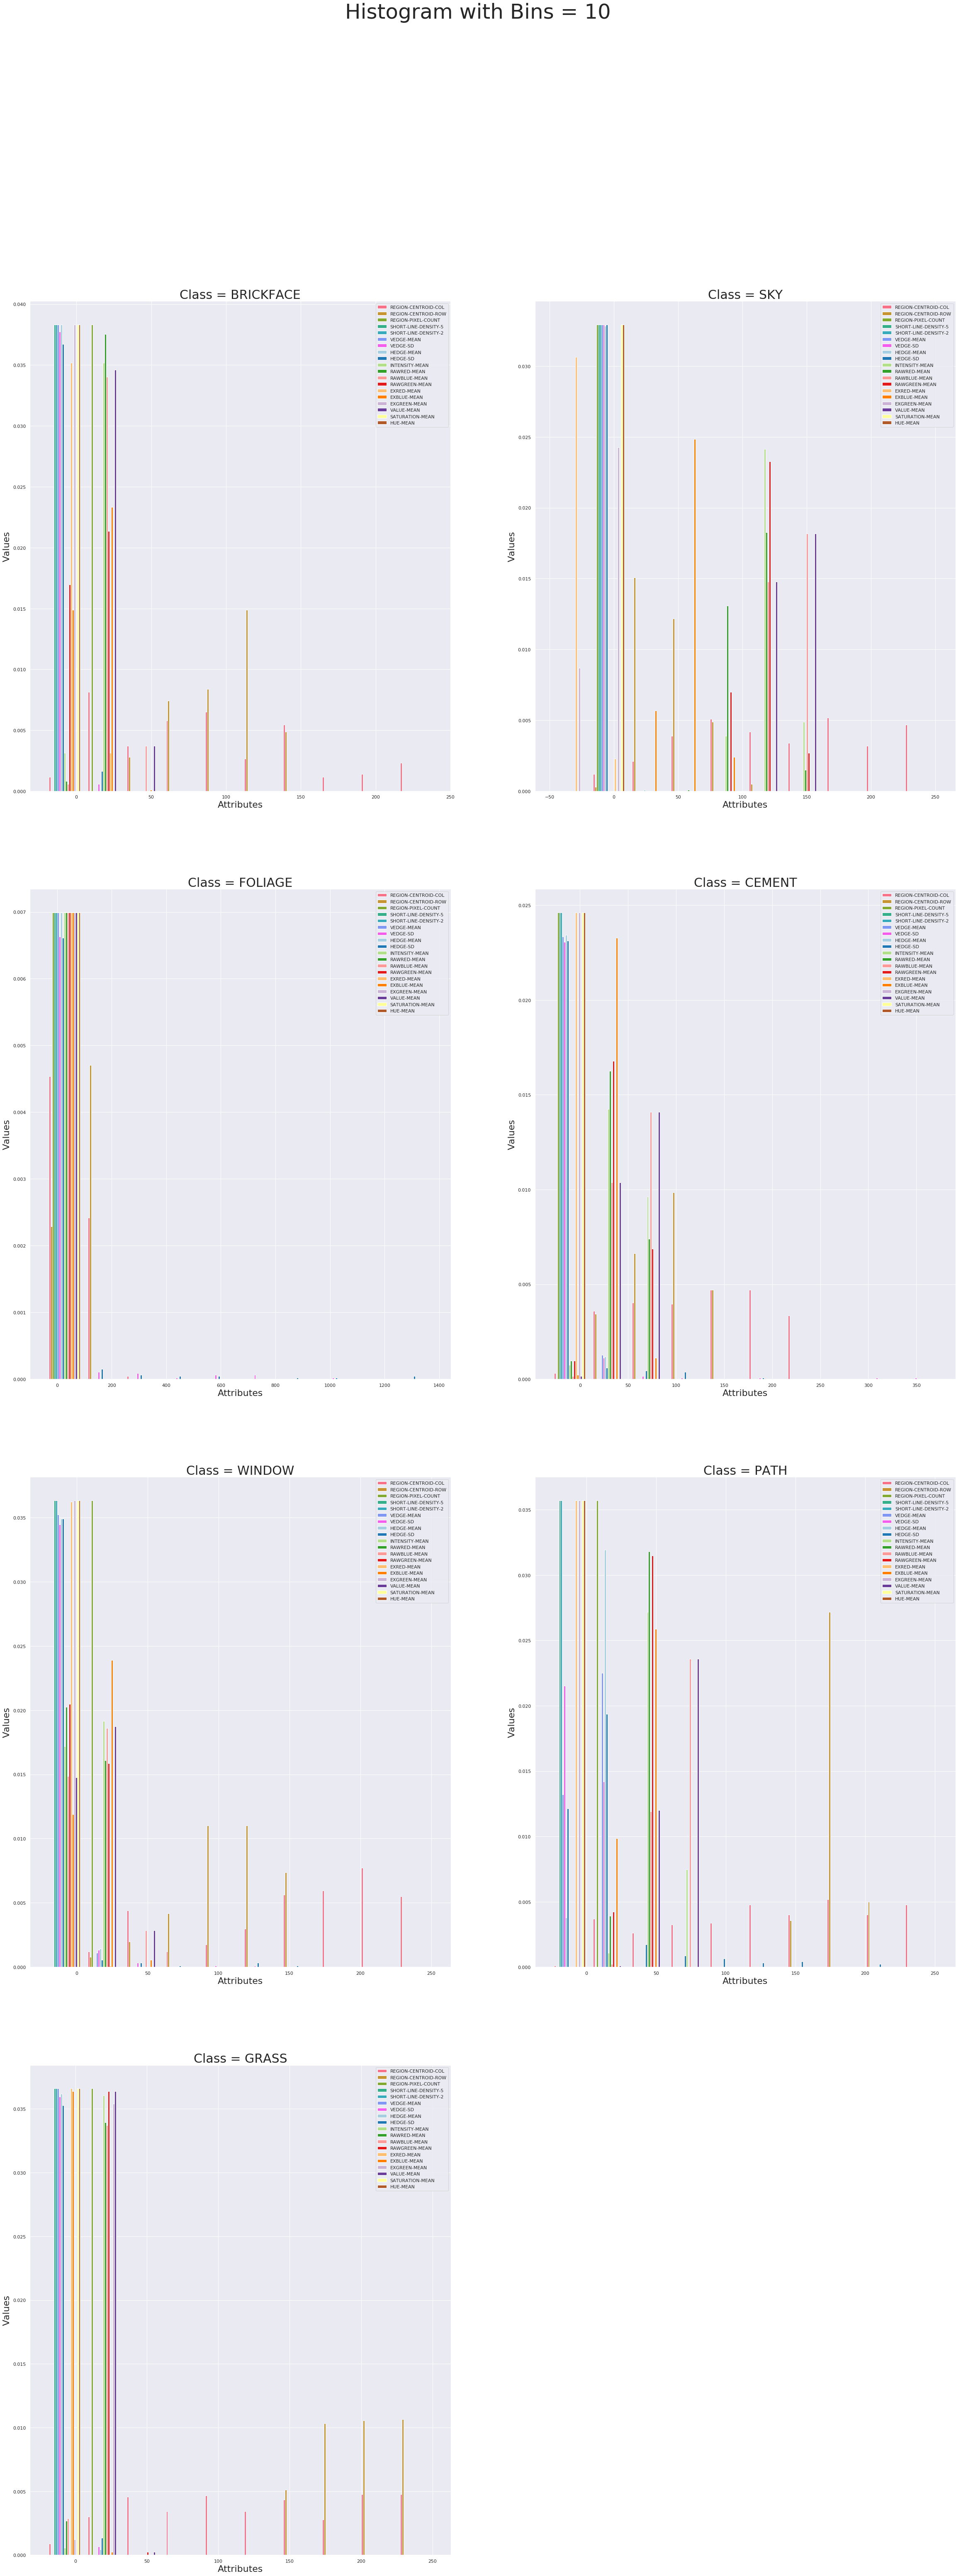

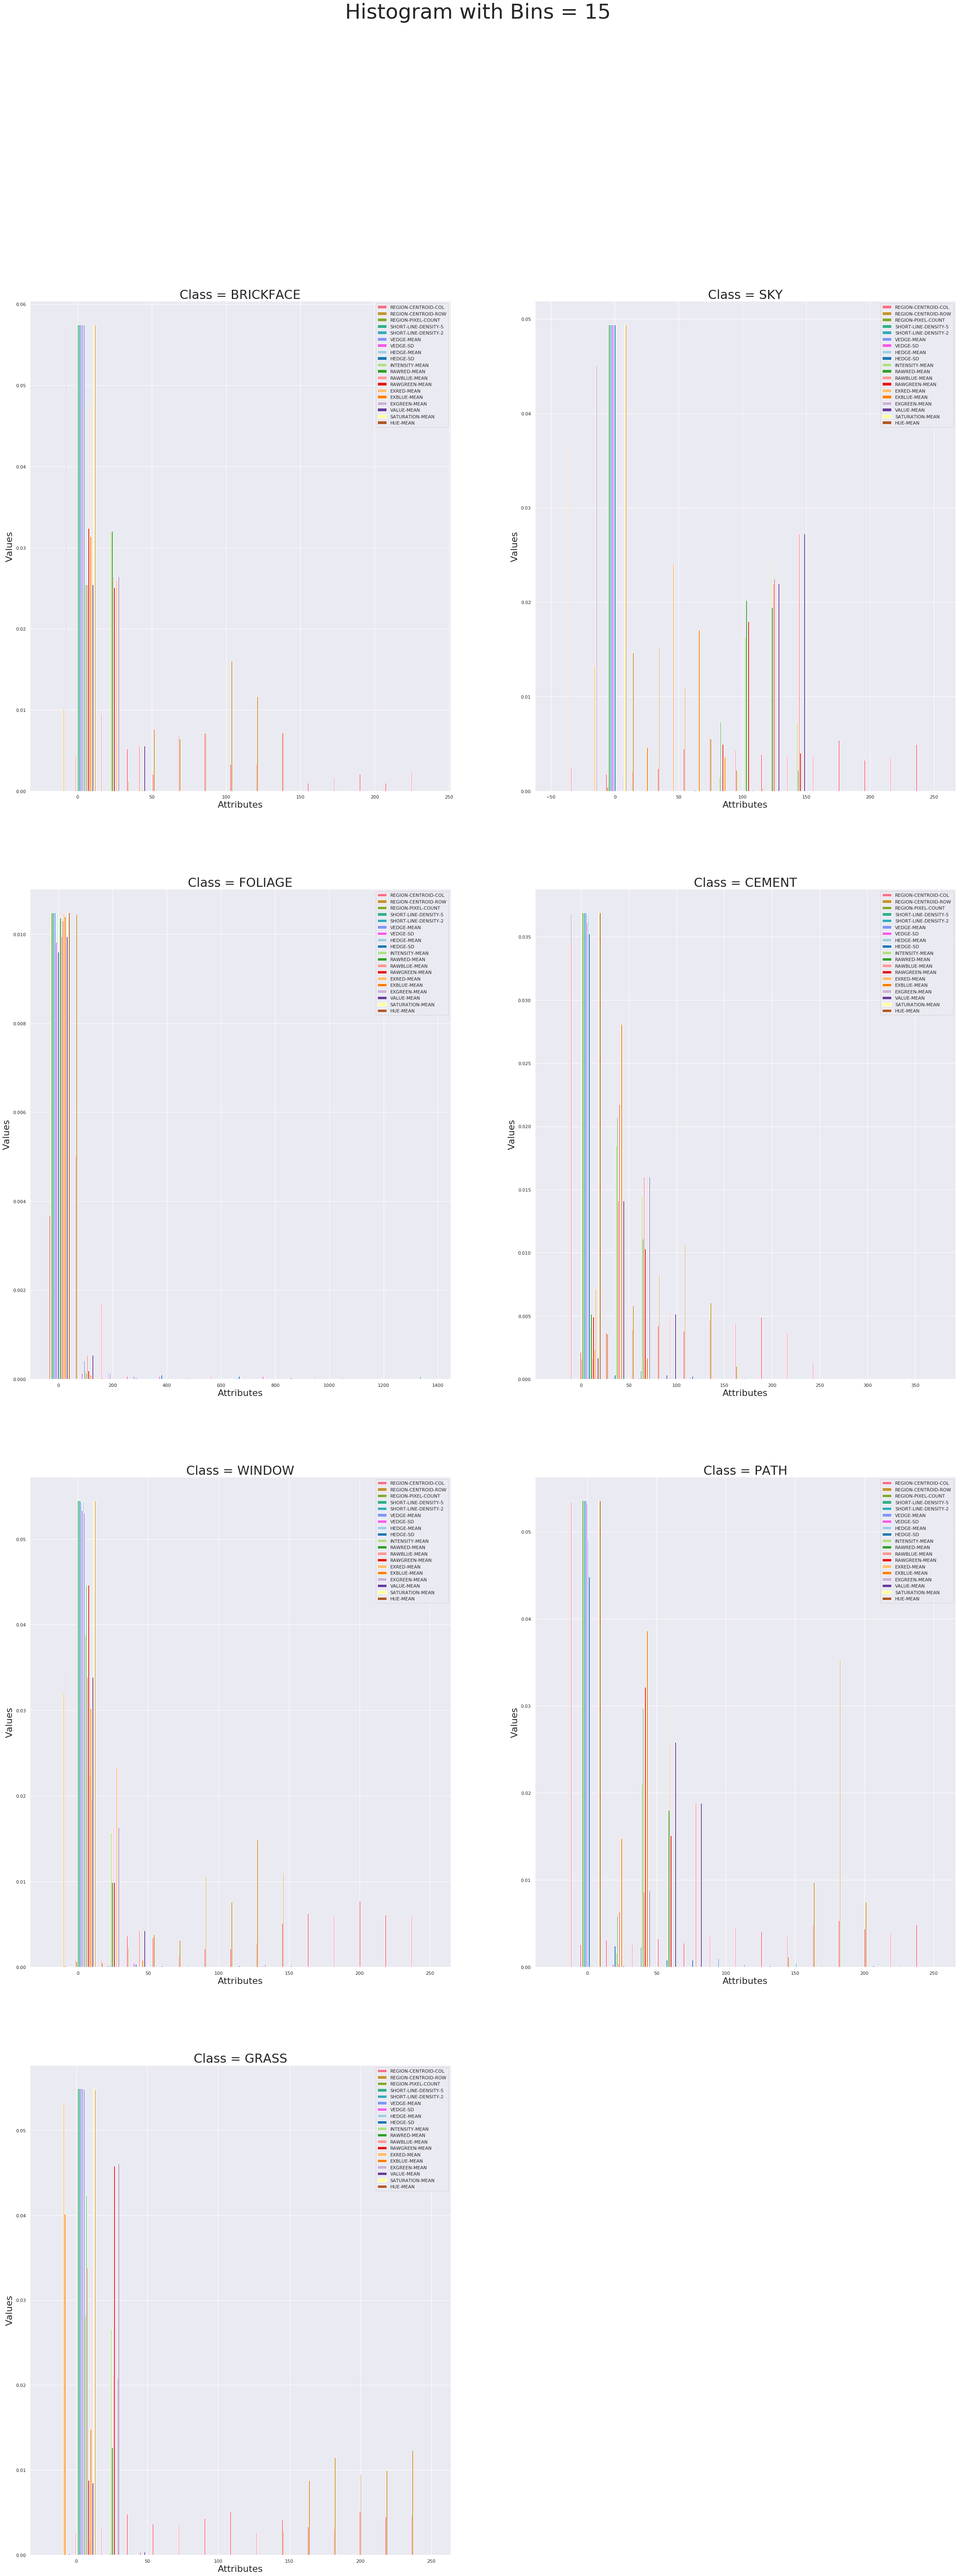

In [14]:
# plot for different bin sizes
for j, bin in enumerate([1, 5, 10, 15]):
    f = plt.figure(figsize=(40,100))
    # plot for each class
    for i, class_name in enumerate(classes):
        
        # Set up the plot
        ax = f.add_subplot(42*10+i+1)
        
        # Draw the plot
        data_to_plot = get_list_of_lists(class_name)
        ax.hist(data_to_plot, bins = bin, density = True, color = colors, label = column_names)
        
        # Title and labels
        ax.set_title('Class = %s' %class_name, size = 30)
        ax.set_xlabel('Attributes', size = 22)
        ax.set_ylabel('Values', size= 22)
        ax.legend()

    f.suptitle('Histogram with Bins = %d' % bin, size = 50)
    plt.show()

## Boxblot

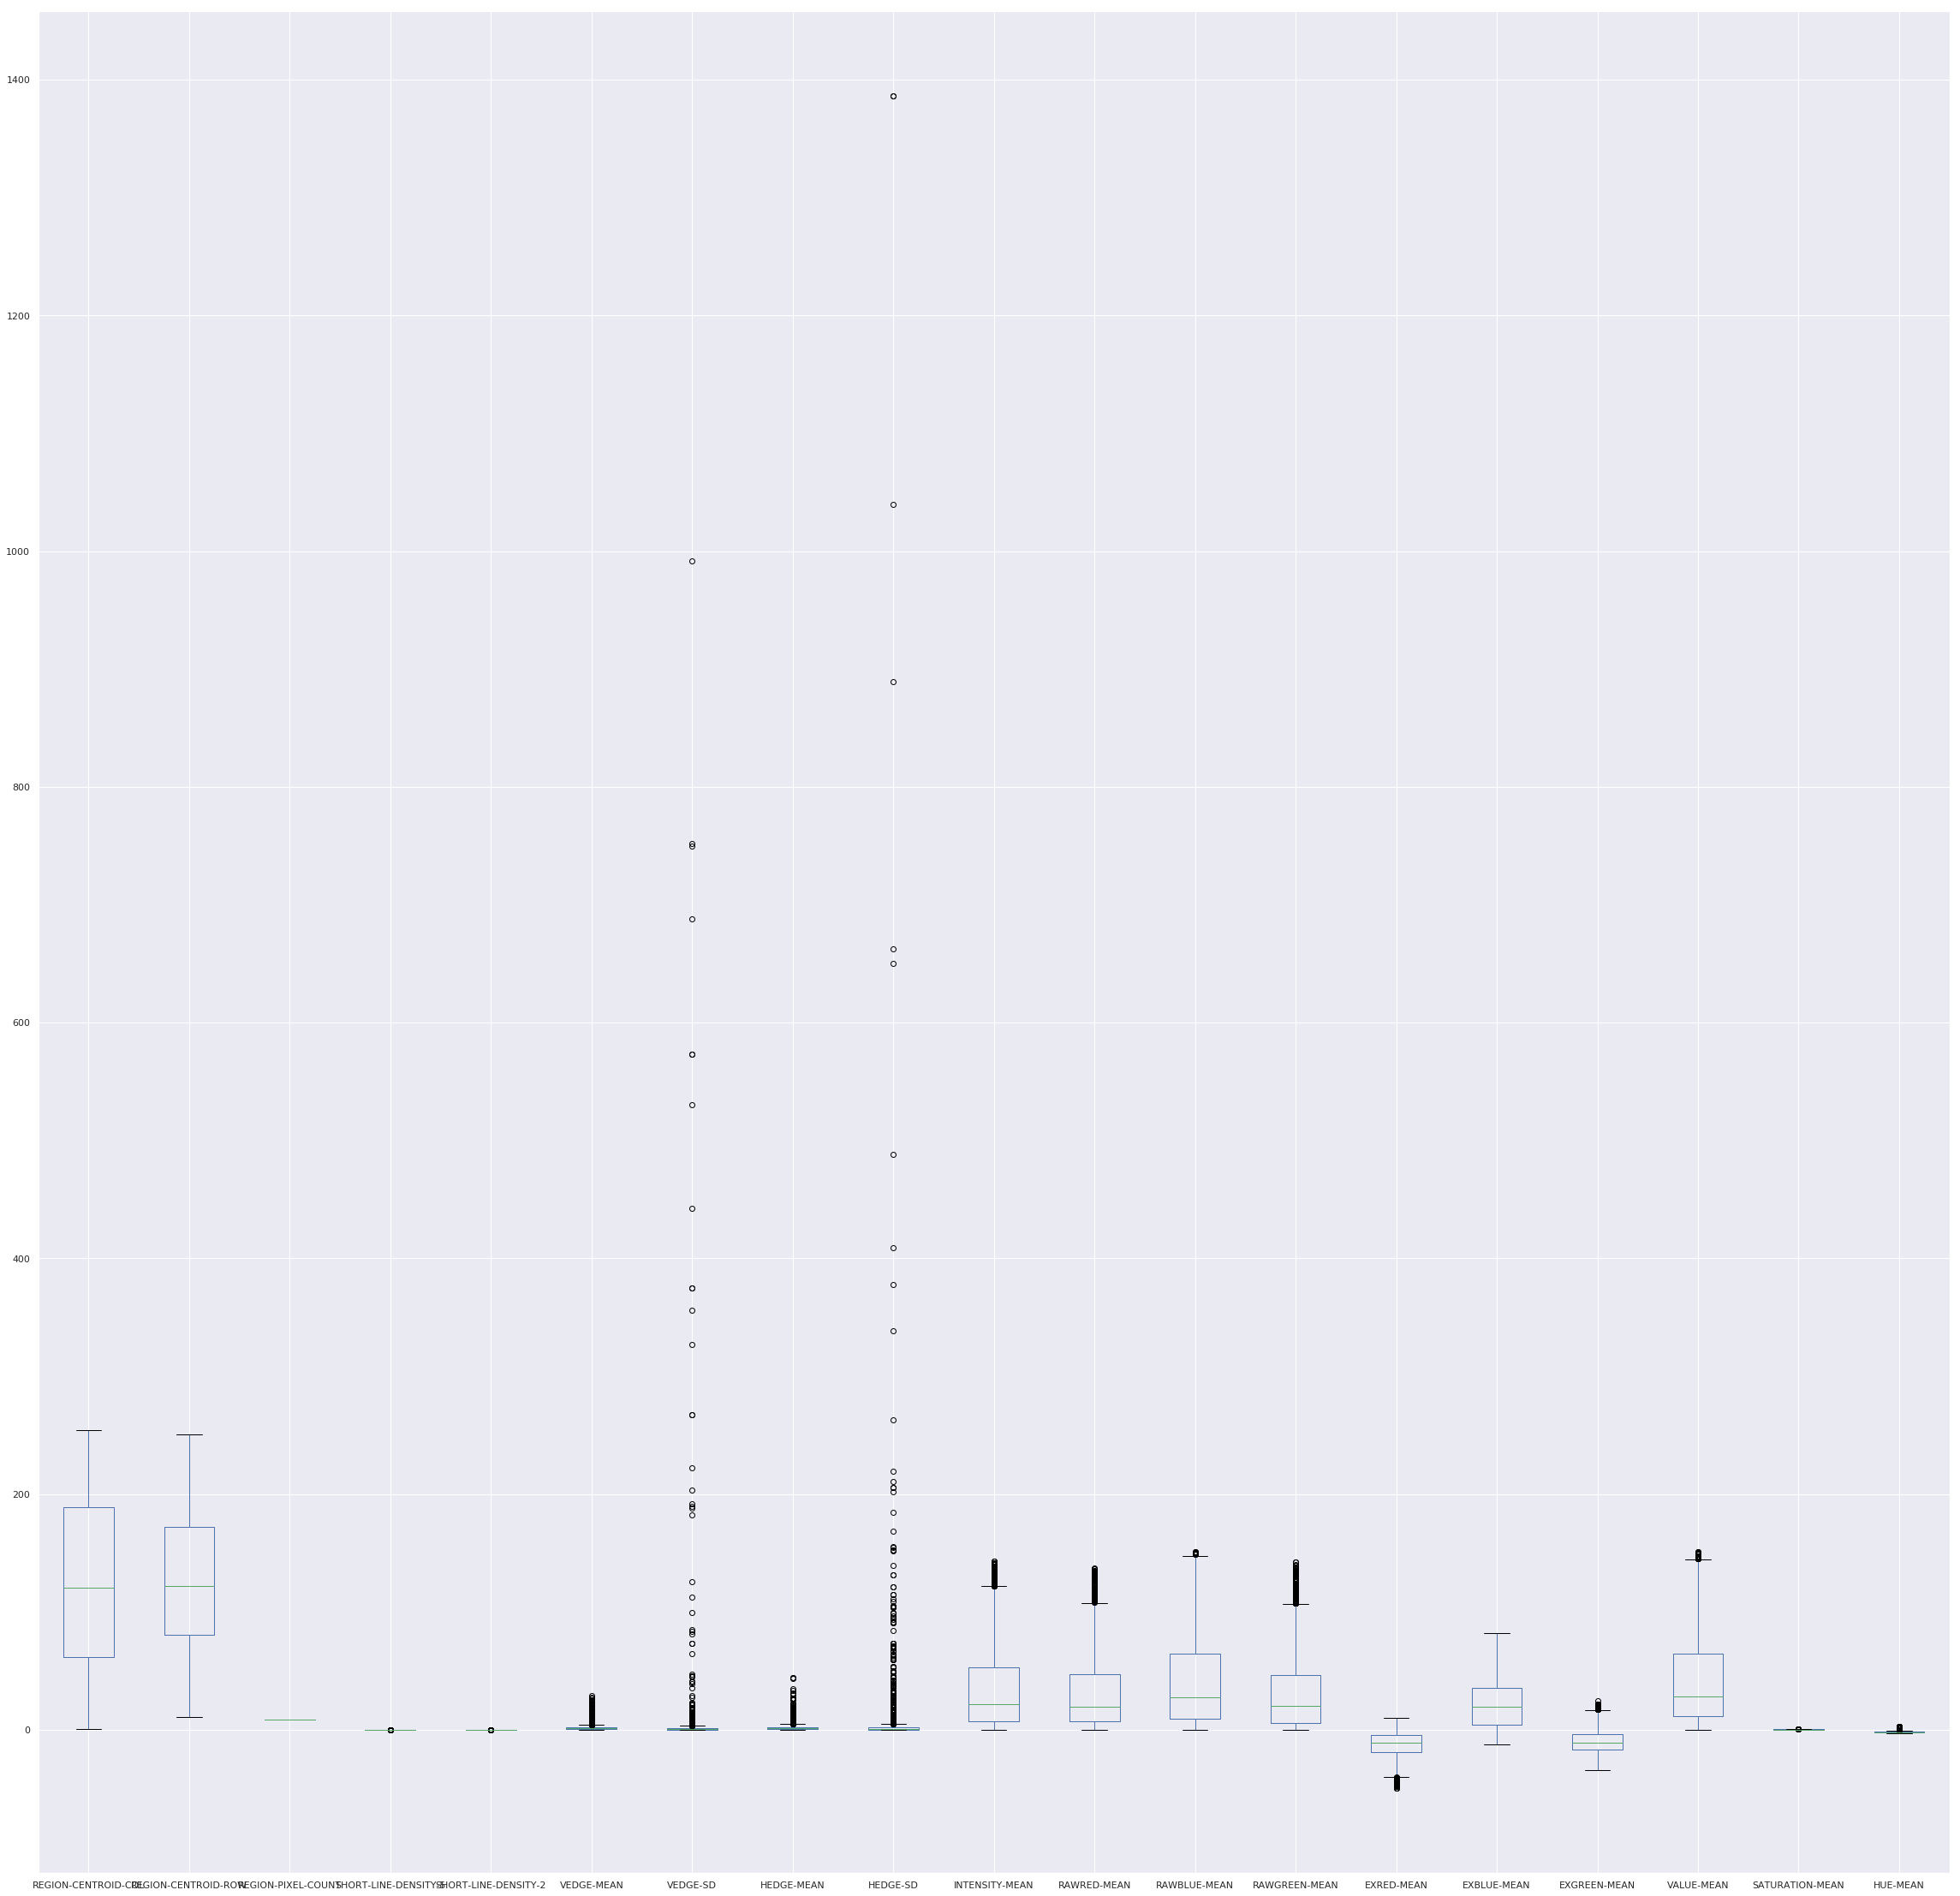

In [15]:
boxplot = data.boxplot(column=column_names, figsize=(40,40))

## Correlation Matrix

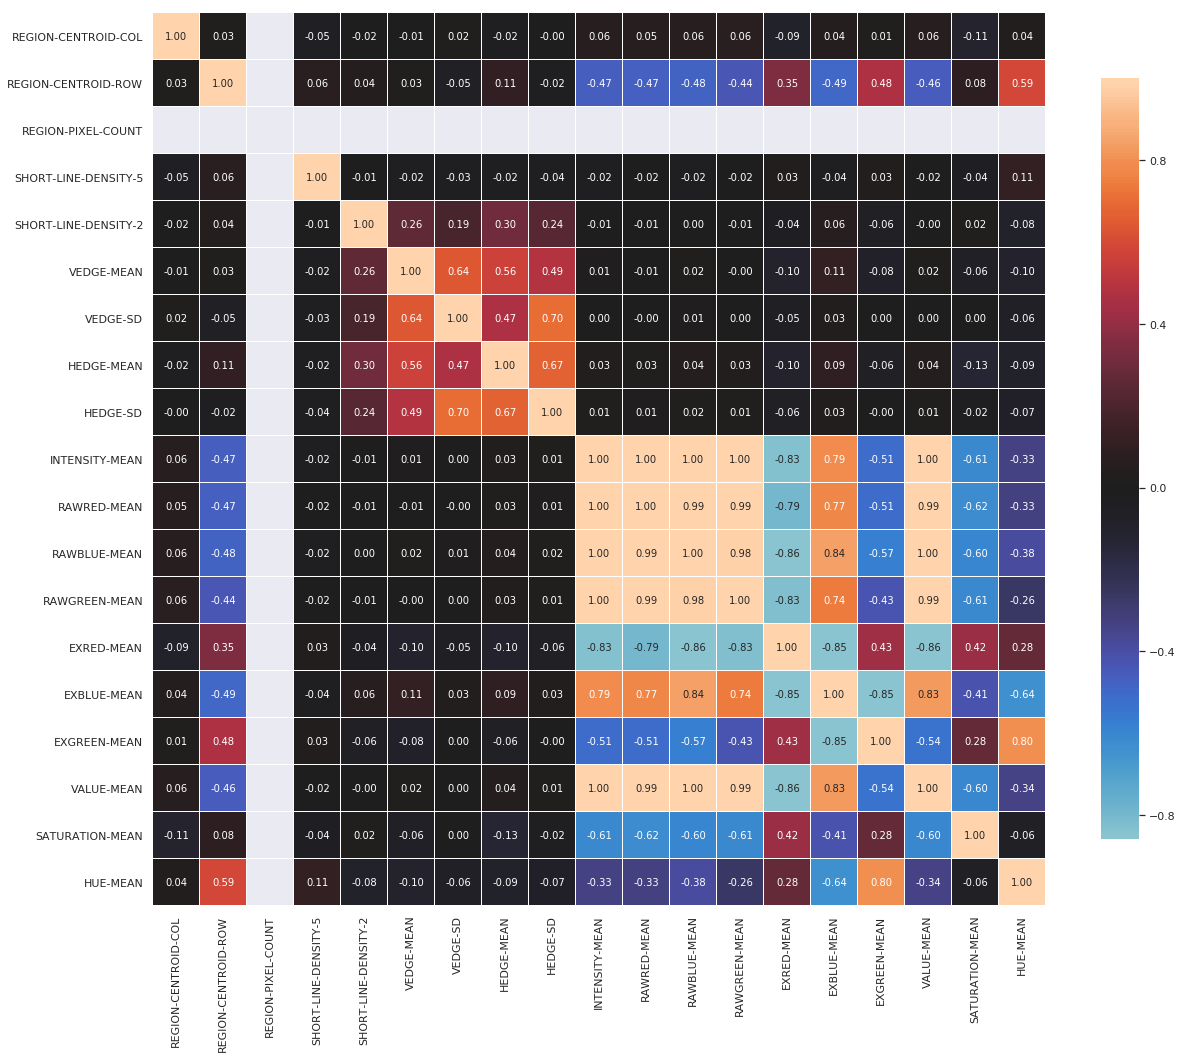

In [16]:
def correlation_heatmap(data):
    correlations = data.corr(method='pearson')
    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(data)

# Preprocessing

## Normalization

### Min-Max scaler

In [17]:
# skip applying 'Min-Max scaler' on constant columns and string ones
cols = data.columns.difference(['Class', 'REGION-PIXEL-COUNT'])
x = data[cols].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_normalized_Min_Max_scaler = pd.DataFrame(x_scaled, columns = cols)
data_normalized_Min_Max_scaler.insert(0,'Class',data.iloc[:,0].values, True)
data_normalized_Min_Max_scaler.insert(3,'REGION-PIXEL-COUNT',data.iloc[:,3].values, True)
data_normalized_Min_Max_scaler

,Class,EXBLUE-MEAN,EXGREEN-MEAN,REGION-PIXEL-COUNT,EXRED-MEAN,HEDGE-MEAN,HEDGE-SD,HUE-MEAN,INTENSITY-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,RAWRED-MEAN,REGION-CENTROID-COL,REGION-CENTROID-ROW,SATURATION-MEAN,SHORT-LINE-DENSITY-2,SHORT-LINE-DENSITY-5,VALUE-MEAN,VEDGE-MEAN,VEDGE-SD
0,BRICKFACE,0.178824,0.444023,9,0.891791,0.014907,0.000224,0.322724,0.043119,0.050810,0.024942,0.053485,0.549407,0.475000,0.545635,0.0,0.000000,0.051546,0.009506,0.000063
1,BRICKFACE,0.167059,0.436433,9,0.917910,0.011180,0.000056,0.355797,0.046476,0.051546,0.027280,0.060778,0.739130,0.508333,0.538580,0.0,0.000000,0.055965,0.011407,0.000269
2,BRICKFACE,0.167059,0.447818,9,0.906716,0.018634,0.000377,0.348892,0.042603,0.047865,0.024942,0.055105,0.411067,0.533333,0.532628,0.0,0.000000,0.050074,0.009506,0.000108
3,BRICKFACE,0.150588,0.449715,9,0.930970,0.024845,0.000342,0.386107,0.040795,0.042710,0.023383,0.056726,0.130435,0.525000,0.573633,0.0,0.000000,0.051546,0.017110,0.000168
4,BRICKFACE,0.183529,0.445920,9,0.882463,0.019876,0.000310,0.313666,0.042086,0.050810,0.024162,0.051053,0.150198,0.416667,0.562919,0.0,0.000000,0.052283,0.024715,0.000377
5,BRICKFACE,0.167059,0.453510,9,0.901119,0.014907,0.000224,0.345557,0.038730,0.044183,0.021824,0.050243,0.059289,0.487500,0.561508,0.0,0.000000,0.047128,0.017110,0.000078
6,BRICKFACE,0.318824,0.299810,9,0.811567,0.054658,0.002298,0.238552,0.139427,0.171576,0.102104,0.142626,0.098814,0.233333,0.436939,0.0,0.333333,0.171576,0.034221,0.000896
7,BRICKFACE,0.243529,0.349146,9,0.882463,0.059627,0.000737,0.285241,0.124968,0.142121,0.094310,0.137763,0.051383,0.412500,0.368848,0.0,0.000000,0.142121,0.058935,0.005397
8,BRICKFACE,0.241176,0.333966,9,0.901119,0.031056,0.000687,0.292453,0.123160,0.139912,0.090413,0.138574,0.039526,0.404167,0.388756,0.0,0.000000,0.139912,0.045627,0.000807
9,BRICKFACE,0.305882,0.301708,9,0.830224,0.028571,0.000879,0.249398,0.148464,0.177467,0.111458,0.154781,0.332016,0.375000,0.404792,0.0,0.000000,0.177467,0.045627,0.001300


### Box plot 

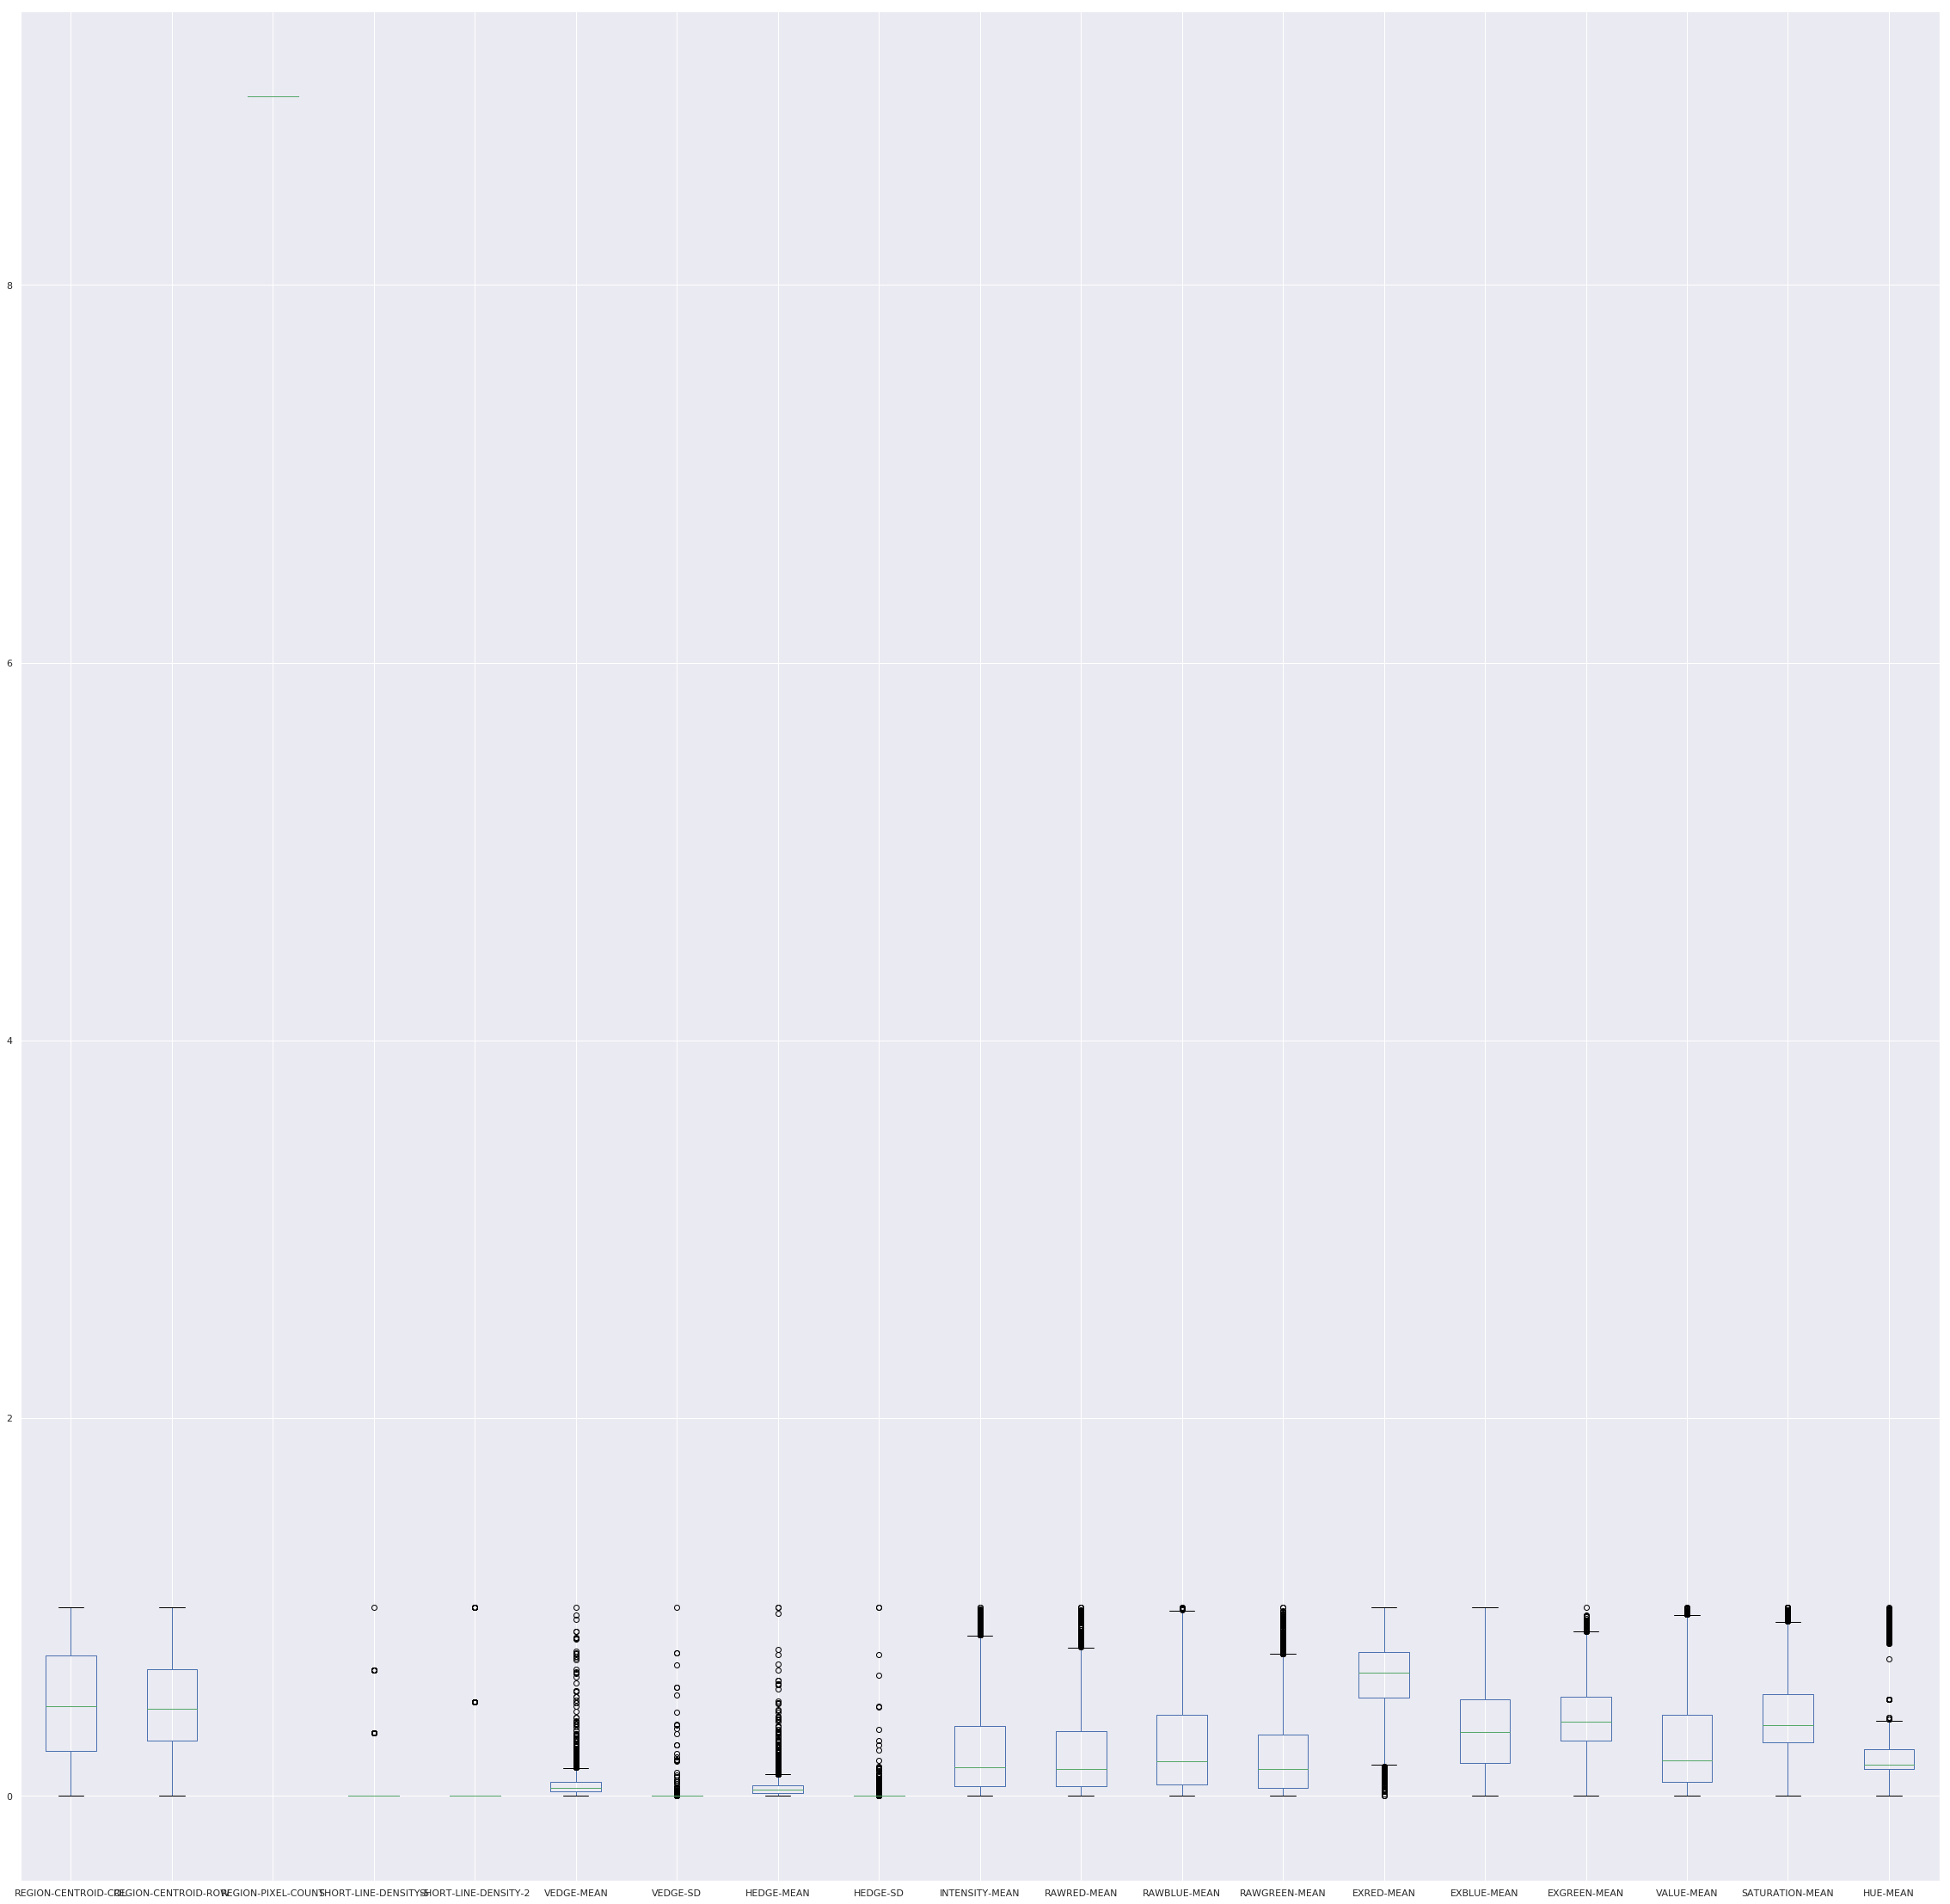

In [18]:
boxplot = data_normalized_Min_Max_scaler.boxplot(column=column_names, figsize=(40,40))

#### The result data spread on less scale, so valuse are more close to each other.

### Z-score

In [19]:
cols = data.columns[1:]
x = data[cols] 
# skip applying 'z-score' on constant columns
x_scaled = x.apply(lambda x: x if np.std(x) == 0 else zscore(x)) 
data_normalized_Z_score = pd.DataFrame(x_scaled, columns = cols)
data_normalized_Z_score.insert(0,'Class',data.iloc[:,0].values, True)
data_normalized_Z_score

,Class,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
0,BRICKFACE,0.206827,0.027539,9,-0.357047,-0.194552,-0.598950,-0.125931,-0.487090,-0.134911,-0.808696,-0.727621,-0.839220,-0.841382,1.393250,-0.866965,0.071789,-0.870602,0.520205,0.156038
1,BRICKFACE,0.864896,0.166738,9,-0.357047,-0.194552,-0.578361,-0.121388,-0.533267,-0.138879,-0.796081,-0.699073,-0.836667,-0.832214,1.527569,-0.923748,0.033306,-0.855067,0.489298,0.283547
2,BRICKFACE,-0.273014,0.271138,9,-0.357047,-0.194552,-0.598950,-0.124940,-0.440914,-0.131320,-0.810636,-0.721277,-0.849433,-0.841382,1.470004,-0.923748,0.091031,-0.875781,0.463221,0.256926
3,BRICKFACE,-1.246407,0.236338,9,-0.357047,-0.194552,-0.516594,-0.123619,-0.363952,-0.132139,-0.817429,-0.714933,-0.867306,-0.847494,1.594729,-1.003245,0.100651,-0.870602,0.642864,0.400405
4,BRICKFACE,-1.177858,-0.216061,9,-0.357047,-0.194552,-0.434239,-0.118993,-0.425521,-0.132895,-0.812577,-0.737137,-0.839220,-0.844438,1.345279,-0.844252,0.081410,-0.868013,0.595925,0.121116
5,BRICKFACE,-1.493183,0.079739,9,-0.357047,-0.194552,-0.516595,-0.125601,-0.487090,-0.134911,-0.825192,-0.740309,-0.862199,-0.853607,1.441221,-0.923748,0.119893,-0.886138,0.589744,0.244069
6,BRICKFACE,-1.356085,-0.981659,9,2.410668,-0.194552,-0.331294,-0.107511,0.005464,-0.086031,-0.446749,-0.378706,-0.420492,-0.538826,0.980699,-0.191244,-0.659387,-0.448554,0.044012,-0.168482
7,BRICKFACE,-1.520602,-0.233461,9,-0.357047,-0.194552,-0.063638,-0.007973,0.067033,-0.122817,-0.501090,-0.397737,-0.522621,-0.569387,1.345279,-0.554657,-0.409248,-0.552124,-0.254292,0.011522
8,BRICKFACE,-1.561732,-0.268261,9,-0.357047,-0.194552,-0.207761,-0.109493,-0.286990,-0.124013,-0.507882,-0.394565,-0.530281,-0.584668,1.441221,-0.566014,-0.486214,-0.559892,-0.167075,0.039329
9,BRICKFACE,-0.547209,-0.390060,9,-0.357047,-0.194552,-0.207761,-0.098589,-0.317775,-0.119478,-0.412787,-0.331126,-0.400066,-0.502153,1.076641,-0.253706,-0.649766,-0.427840,-0.096823,-0.126668


### Box plot

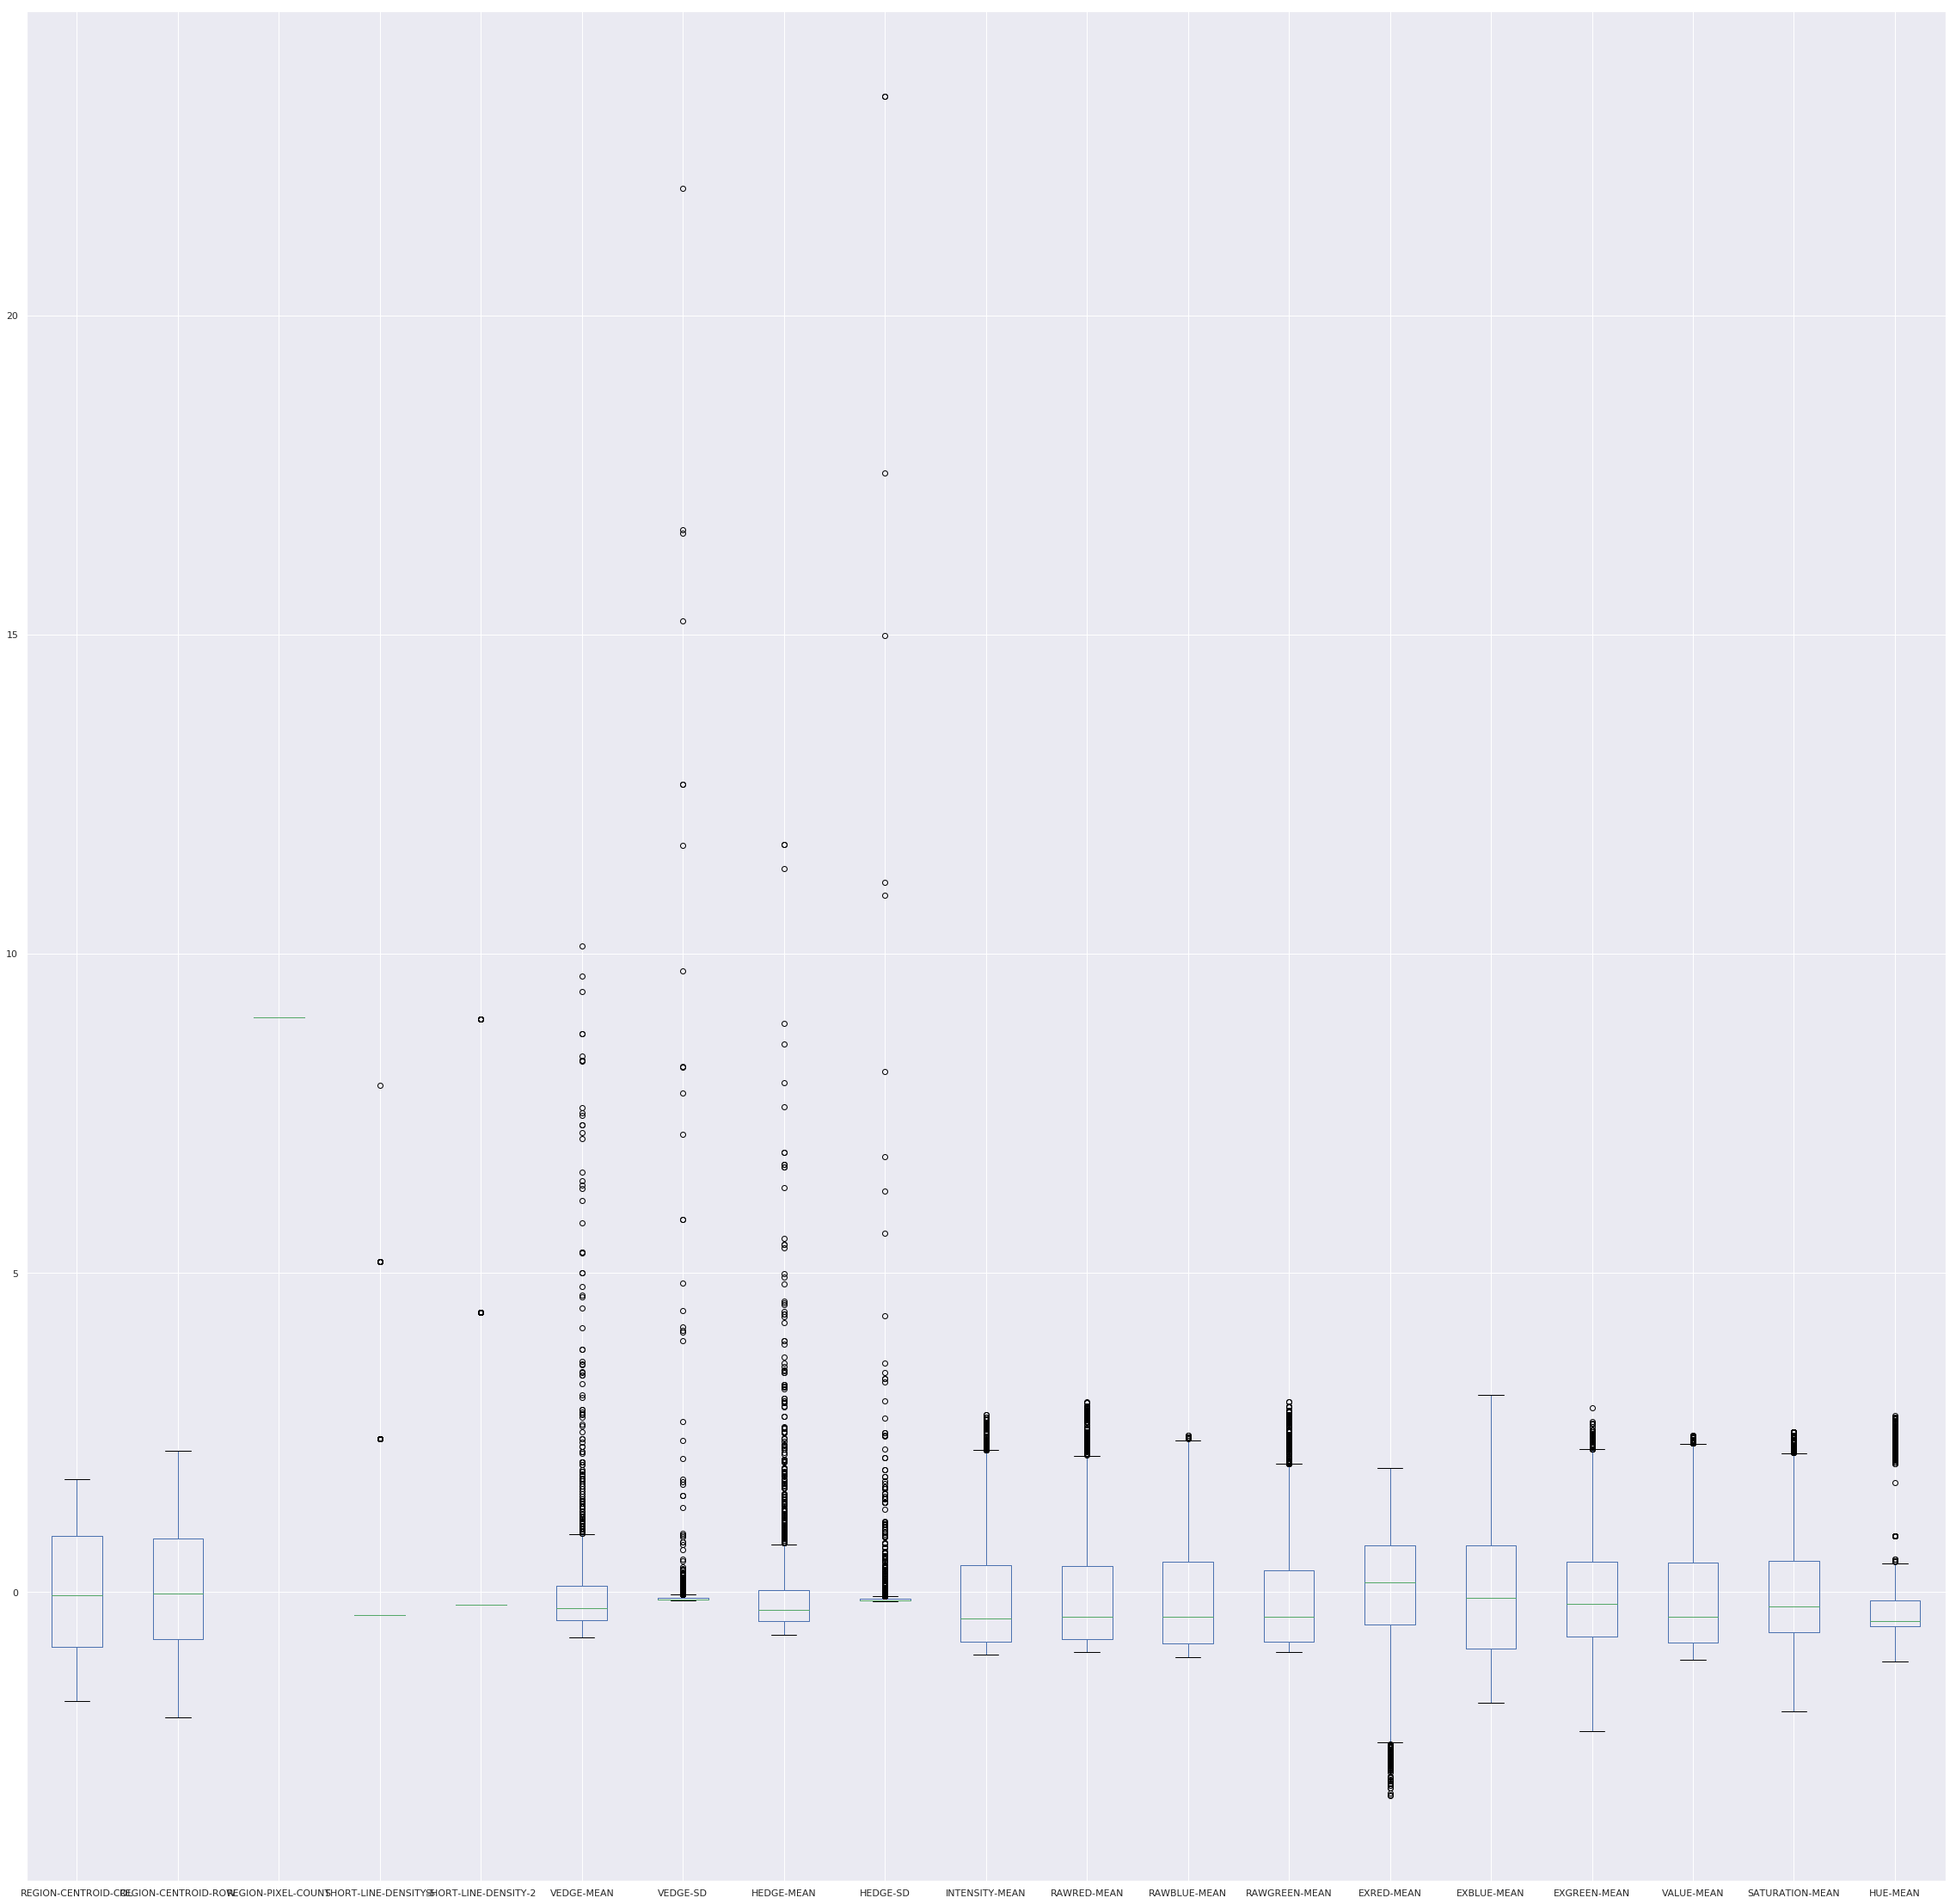

In [20]:
boxplot = data_normalized_Z_score.boxplot(column=column_names, figsize=(40,40))

#### The result data spread on less scale, so valuse are more close to each other.

# Dimensionality reduction

## Feature Projection

In [21]:
# initiate columns names for pca and feture selection
pca_columns =[] 
feature_columns = []
for i in range(1,11):
    pca_columns.append('principal component {}'.format(i))
    feature_columns.append('Feture {}'.format(i))

In [22]:
# pass desired sum of varince ratio we need to be captured 
pca = PCA(0.95)
principalComponents = pca.fit_transform(data_normalized_Z_score.iloc[:,1:])

In [23]:
pca.n_components_

10

### variance ratio

In [24]:
pca.explained_variance_ratio_

array([0.42341135, 0.16203649, 0.09959451, 0.05857283, 0.05197997,
       0.05050372, 0.04041415, 0.03120143, 0.02999802, 0.02195028])

In [25]:
principalComponents

array([[-2.34100796, -0.56863828, -0.65054785, ..., -0.62045015,
         0.27640935,  0.26303246],
       [-2.3979165 , -0.59856841, -0.4320846 , ..., -0.6418406 ,
         0.31352126,  0.30148527],
       [-2.45623995, -0.54369376, -0.53203669, ..., -0.59973604,
         0.27129803,  0.36783974],
       ...,
       [-1.99894507, -0.43320721, -0.68549979, ..., -0.04033063,
        -0.14995966,  0.48624812],
       [-1.87196515, -0.07174812, -0.55768194, ...,  0.11339926,
         0.14416504,  0.16395601],
       [-1.72972287, -0.20925214, -0.20913794, ..., -0.01727218,
        -0.23358528,  0.20893724]])

### Correlation matrix Visualization

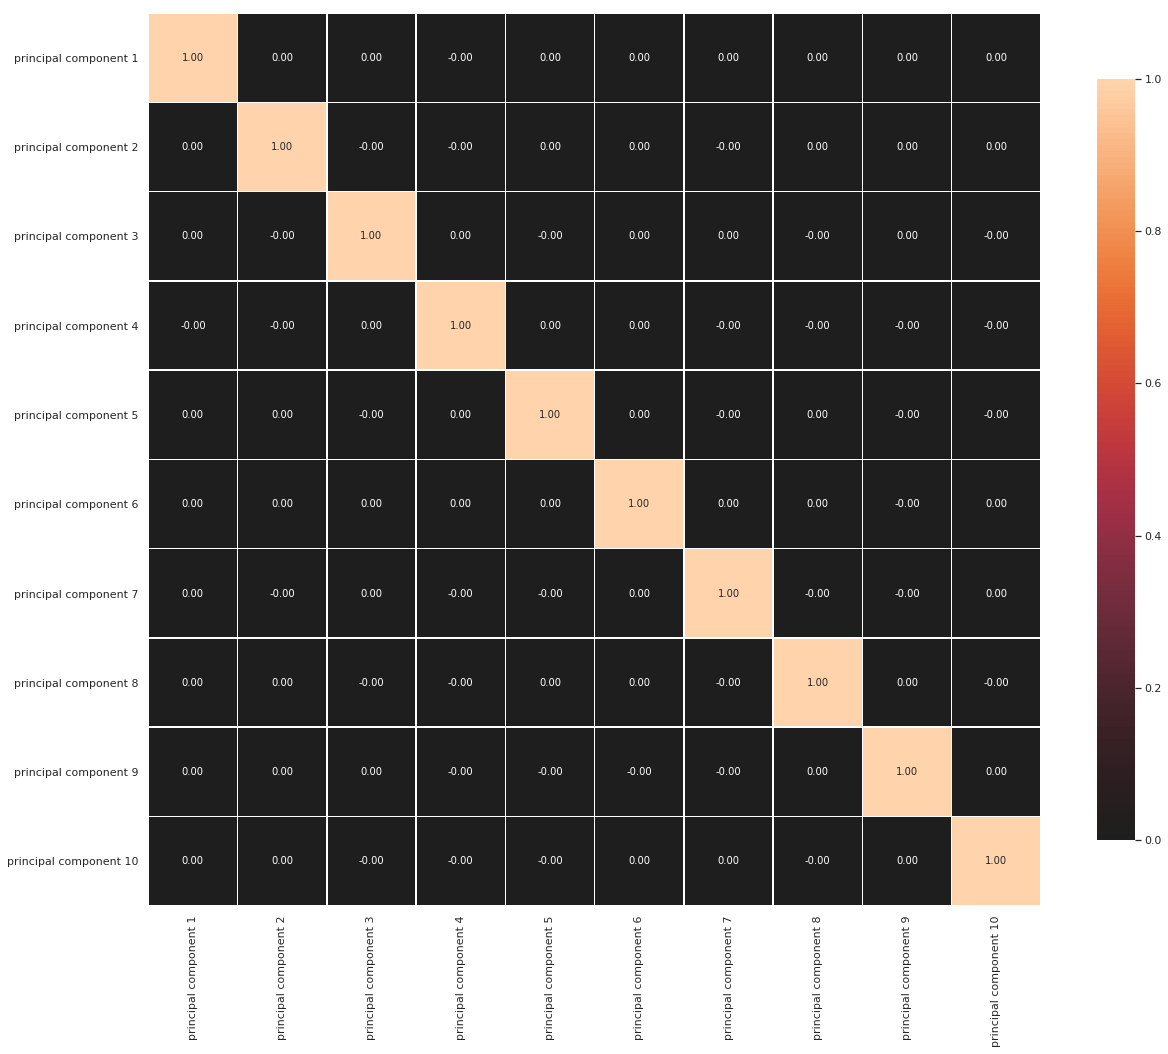

In [26]:
pca_data = pd.DataFrame(principalComponents, columns = pca_columns)
pca_data.insert(0,'Class',data.iloc[:,0].values, True)
correlation_heatmap(pca_data)

### Conclusion 

- Principal component analysis convert a set of observations of correlated variables into a set of values of linearly uncorrelated variables called principal components

- less than the half of attributes cn describe the data with 0.95 percent  


## Feature Selection
applied on 'z-score' normalized data

In [27]:
sk_best = SelectKBest(k=10)
sk_best_data = sk_best.fit_transform(data_normalized_Z_score.iloc[:,1:],data_normalized_Z_score.iloc[:,0])

/home/magho/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [2] are constant.
  UserWarning)
/home/magho/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [28]:
sk_best.scores_

array([  44.80244307, 1287.04510386,           nan,   11.85597867,
         13.18728836,   42.38691429,   15.46383553,   57.53101313,
         12.93347683, 4347.7389768 , 4058.50885872, 4227.9003788 ,
       4336.08001445, 1079.89210445, 1212.11217413, 1928.16501646,
       4107.57680069,  484.9597623 , 5993.29821762])

### Correlation matrix Visualization

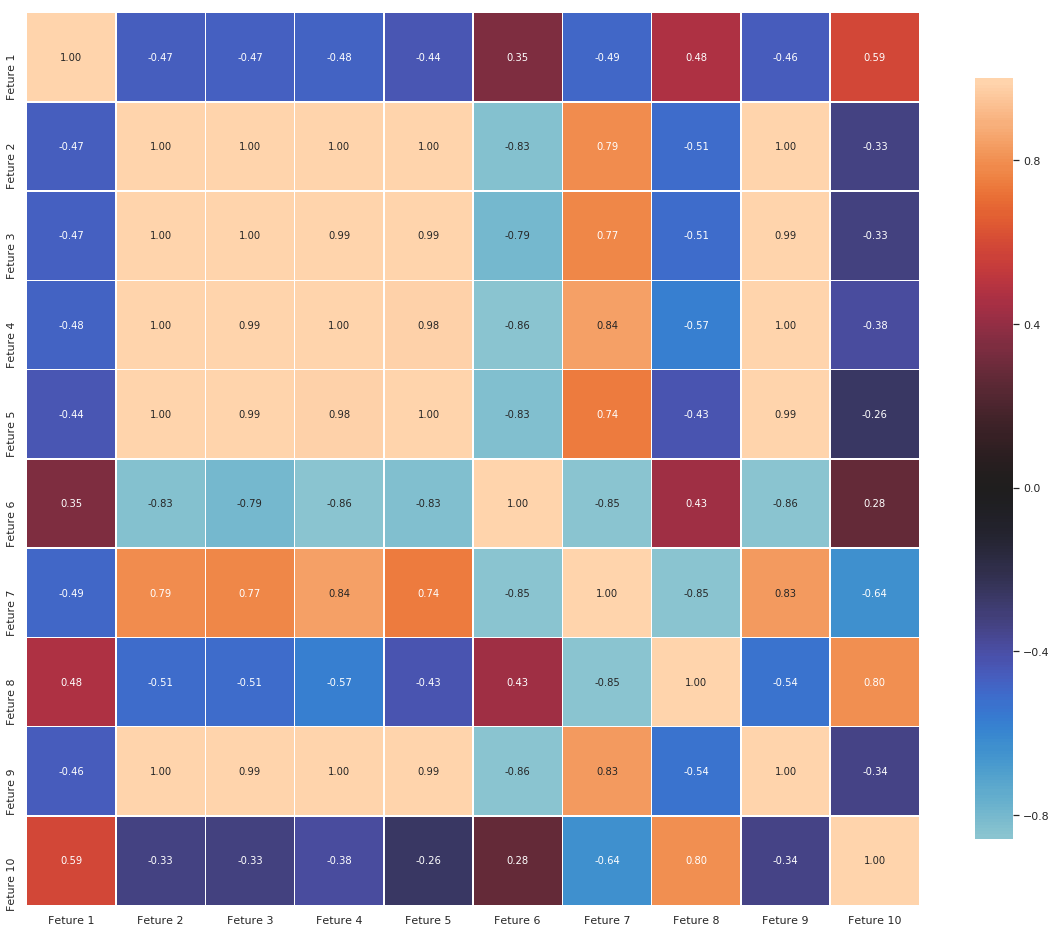

In [29]:
sk_best_data = pd.DataFrame(sk_best_data, columns = feature_columns)
sk_best_data.insert(0,'Class',data.iloc[:,0].values, True)
correlation_heatmap(sk_best_data)

### Conclusion

- Feature Selection select those features which contribute most to your prediction variable or output in which you are interested in.

- These features are highly correlated  